<a href="https://colab.research.google.com/github/Ozi-cyber/Thesis-Project/blob/main/ProtoNet_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting gdrive for file path
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive
%ls

Mounted at /content/drive
/content/drive/MyDrive
 appsheet/
'Artificial Intelligence Exercises'/
 BLAST1_012.jpg
'Calib&Melendres_Project'/
 Calib-og/
 CALIB-OG/
'Calib-og (1)'/
 CALIB-OG_2020-00707.png
 Calib-og_AA2.3_EDA/
 CALIB-OG_Application-for-Graduation.pdf
 Calib-og_BSCS2A_PhilippineFolkDance_ReflectiveJournal.pdf
 Calib-og_BSCS2A_ReflectiveJournalBadminton.pdf
 Calib-og_BSCS2A_videoreport_journal.pdf
 Calib-og_BSCS_videoreport_journal.pdf
'Calib-og,Cedrick John_Cert-of-Indigency.pdf'
'Calib-og, Cedrick John D.'/
'CALIB-OG, Cedrick John D.'/
 CALIB-OG_CedrickJohn_D./
'Calib-og, Cedrick John, D._COR.pdf'
 Calib-og_Cedrick_John_DesignAlgorithmWorks/
'Calib-og_Cedrick John_D._MiraclesInHeaven_Reflection.pdf'
 CALIB-OG_Cedrick_John_D..png
'Calib-og_Cedrick John_D._Reflection Paper.pdf'
 Calib-og_CedrickJohn_Module1Lesson2.pdf
 Calib-og_CedrickJohn_Module1Lesson3.pdf
'Calib-og_CedrickJohn_Module1Lesson4 (1).pdf'
 Calib-og_CedrickJohn_Module1Lesson4.pdf
 Calib-og_CedrickJohn_Module2L

In [ ]:
#install easyfsl library
!pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 373.3 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
#import necessary libraries
from google.colab import files

import torch
import pandas as pd
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import resnet34
from torchvision.models import resnet50
from torchvision.models import resnet101
from torchvision.models import resnet152, ResNet152_Weights
from tqdm import tqdm
import PIL.Image
import os

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average, evaluate, evaluate_on_one_task
from easyfsl.datasets import EasySet as es
from easyfsl.datasets import SupportSetFolder
from easyfsl.methods import PrototypicalNetworks, FewShotClassifier

from skimage import io
from pathlib import Path
from typing import Any, Callable, List, Optional, Tuple, Union
from torch import Tensor
from os import listdir


import copy
import random
from statistics import mean

import numpy as np
import torch
from torch import nn






In [ ]:
#load the data

IMAGENET_NORMALIZATION = {"mean": [0.485, 0.456, 0.406], "std": [0.229, 0.224, 0.225]}

train_file = Path("/content/drive/MyDrive/tomato_bg_labels.json")
test_file = Path("/content/drive/MyDrive/test_validated.json")
train_dataset = es(specs_file = train_file, training = True)
test_dataset = es(specs_file = test_file,
                  transform = transforms.Compose([
                        transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        transforms.Normalize(**IMAGENET_NORMALIZATION)
                  ]))


In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
convolutional_network = resnet152(pretrained=True)
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).to(device)


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 119MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 120MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# load model
model.load_state_dict(torch.load('Trained-Resnet18.pt'))

In [ ]:
# load model
model.load_state_dict(torch.load('Trained-Resnet34.pt'))

<All keys matched successfully>

In [ ]:
# load model
model.load_state_dict(torch.load('Trained-Resnet50.pt'))

<All keys matched successfully>

In [ ]:
# load model
model.load_state_dict(torch.load('Trained-Resnet101.pt'))

<All keys matched successfully>

In [ ]:
# load model
model.load_state_dict(torch.load('Trained-Resnet152.pt'))

<All keys matched successfully>

In [ ]:
N_WAY = 6 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 5 # Number of images per class in the query set
N_EVALUATION_TASKS = 100

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_dataset.get_labels = lambda: [instance[1] for instance in test_dataset]
test_sampler = TaskSampler(
    test_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_dataset,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

In [ ]:
#plotting images... need nato ug daghan pang data para mutaas ang accuracy
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

In [ ]:
test_dataset.class_names

['Bacterial Blight',
 'Brown Spot',
 'Healthy',
 'Rice Blast',
 'Sheath Blight',
 'Tungro']

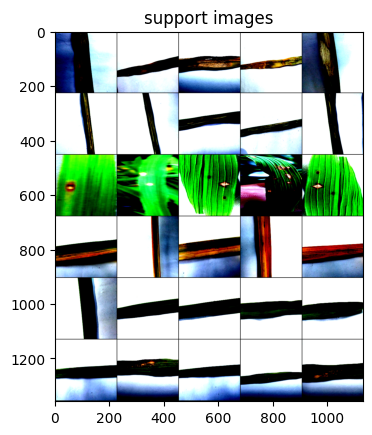

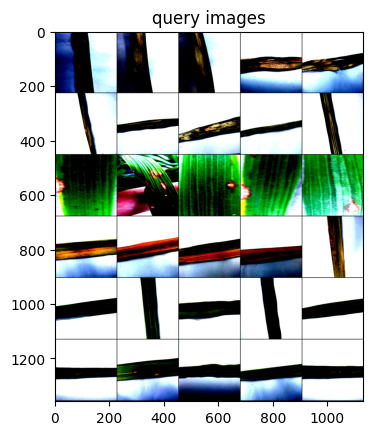

In [ ]:
plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [ ]:
model.eval()
example_scores = model(
    example_support_images.to(device),
    example_support_labels.to(device),
    example_query_images.to(device),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    print(
        f"{test_dataset.class_names[example_class_ids[example_query_labels[i]]]} / {test_dataset.class_names[example_class_ids[example_predicted_labels[i]]]}"
    )

Ground Truth / Predicted
Healthy / Healthy
Healthy / Healthy
Healthy / Healthy
Healthy / Healthy
Healthy / Healthy
Tungro / Tungro
Tungro / Tungro
Tungro / Tungro
Tungro / Tungro
Tungro / Healthy
Sheath Blight / Sheath Blight
Sheath Blight / Sheath Blight
Sheath Blight / Sheath Blight
Sheath Blight / Sheath Blight
Sheath Blight / Sheath Blight
Bacterial Blight / Bacterial Blight
Bacterial Blight / Bacterial Blight
Bacterial Blight / Bacterial Blight
Bacterial Blight / Bacterial Blight
Bacterial Blight / Bacterial Blight
Brown Spot / Tungro
Brown Spot / Tungro
Brown Spot / Brown Spot
Brown Spot / Brown Spot
Brown Spot / Brown Spot
Rice Blast / Rice Blast
Rice Blast / Rice Blast
Rice Blast / Rice Blast
Rice Blast / Rice Blast
Rice Blast / Rice Blast


In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.to(device), support_labels.to(device), query_images.to(device))
            .detach()
            .data,
            1,
        )[1]
        == query_labels.to(device)
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )

evaluate(test_loader)

100%|██████████| 100/100 [03:19<00:00,  1.99s/it]

Model tested on 100 tasks. Accuracy: 58.63%


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
convolutional_network = resnet152(pretrained=True)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network).to(device)

# Training a meta-learning algorithm

> Train the model from scratch



In [ ]:
N_WAY = 6 # Number of classes in a task
N_SHOT = 5 # Number of images per class in the support set
N_QUERY = 5 # Number of images per class in the query set
N_TRAINING_EPISODES = 20000

train_dataset.get_labels = lambda: [instance[1] for instance in train_dataset]
train_sampler = TaskSampler(
    train_dataset, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.to(device), query_images.to(device)
    )

    loss = criterion(classification_scores, query_labels.to(device))
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 20000/20000 [1:37:12<00:00,  3.43it/s, loss=0.09]


In [ ]:
#save the model state (weights)
torch.save(model.state_dict(), 'NewTrained-Resnet18.pt')

In [ ]:
#save the model state (weights)
torch.save(model.state_dict(), 'Trained-Resnet34.pt')

In [ ]:
#save the model state (weights)
torch.save(model.state_dict(), 'Trained-Resnet50.pt')

In [ ]:
#save the model state (weights)
torch.save(model.state_dict(), 'Trained-Resnet101.pt')

In [ ]:
#save the model state (weights)
torch.save(model.state_dict(), 'Trained-Resnet152.pt')

In [ ]:
#Load state model
model.load_state_dict(torch.load('Protonet.pt'))

<All keys matched successfully>

In [ ]:
#save the model state (weights)
torch.save(model.state_dict(), 'Resnet18-Trained-fScratch.pt')

In [ ]:
evaluate(test_loader)

100%|██████████| 100/100 [02:16<00:00,  1.37s/it]

Model tested on 100 tasks. Accuracy: 67.97%


Make predictions with one picture

Predicted Query Image: Rice Blast


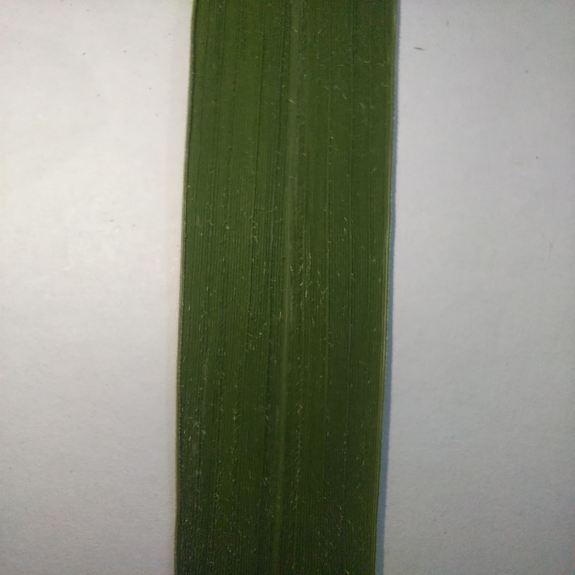

In [ ]:
img_dir = "/content/drive/MyDrive/Final Query Set/Image 12.jpg"
pil_img = PIL.Image.open(img_dir)

torch_img = transforms.Compose([
  transforms.Resize([int(84 * 1.15), int(84 * 1.15)]),
  transforms.CenterCrop(84),
  transforms.ToTensor()
  ])(pil_img)

torch_img2 = transforms.Compose([
  transforms.Resize([int(500 * 1.15), int(500 * 1.15)])
  ])(pil_img)

tensor_normalized_image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(torch_img)[None]
model.eval()
example_scores = model(
    example_support_images.to(device),
    example_support_labels.to(device),
    tensor_normalized_image.to(device),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)


print("Predicted Query Image: " + test_dataset.class_names[example_class_ids[example_predicted_labels]])
torch_img2